# 多GPU的简洁实现
:label:`sec_multi_gpu_concise`

每个新模型的并行计算都从零开始实现是无趣的。此外，优化同步工具以获得高性能也是有好处的。下面我们将展示如何使用深度学习框架的高级API来实现这一点。数学和算法与 :numref:`sec_multi_gpu`中的相同。不出所料，你至少需要两个GPU来运行本节的代码。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## [**简单网络**]

让我们使用一个比 :numref:`sec_multi_gpu`的LeNet更有意义的网络，它依然能够容易地和快速地训练。我们选择的是 :cite:`He.Zhang.Ren.ea.2016`中的ResNet-18。因为输入的图像很小，所以稍微修改了一下。与 :numref:`sec_resnet`的区别在于，我们在开始时使用了更小的卷积核、步长和填充，而且删除了最大汇聚层。


In [2]:
#@save
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

## 网络初始化


我们将在训练回路中初始化网络。请参见 :numref:`sec_numerical_stability`复习初始化方法。


In [3]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

## [**训练**]

如前所述，用于训练的代码需要执行几个基本功能才能实现高效并行：

* 需要在所有设备上初始化网络参数。
* 在数据集上迭代时，要将小批量数据分配到所有设备上。
* 跨设备并行计算损失及其梯度。
* 聚合梯度，并相应地更新参数。

最后，并行地计算精确度和发布网络的最终性能。除了需要拆分和聚合数据外，训练代码与前几章的实现非常相似。


In [4]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    # 0,1,2...
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            # 训练逻辑：总和在第一块GPU上
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

让我们看看这在实践中是如何运作的。我们先[**在单个GPU上训练网络**]进行预热。


测试精度：0.89，14.0秒/轮，在[device(type='cuda', index=0)]


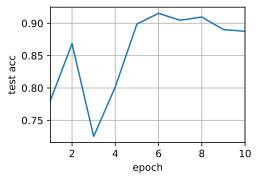

In [5]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

接下来我们[**使用2个GPU进行训练**]。与 :numref:`sec_multi_gpu`中评估的LeNet相比，ResNet-18的模型要复杂得多。这就是显示并行化优势的地方，计算所需时间明显大于同步参数需要的时间。因为并行化开销的相关性较小，因此这种操作提高了模型的可伸缩性。


测试精度：0.86，9.1秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


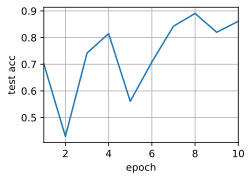

In [6]:
train(net, num_gpus=2, batch_size=512, lr=0.2)# batch_size lr *2!!!（数据集小无法用太大batch_size）

## 小结


* 神经网络可以在（可找到数据的）单GPU上进行自动评估。
* 每台设备上的网络需要先初始化，然后再尝试访问该设备上的参数，否则会遇到错误。
* 优化算法在多个GPU上自动聚合。


pytorch中，网络被Dataparallel“包装”后，在前向过程会把输入tensor自动分配到每个显卡上。
而Dataparallel使用的是master-slave的数据并行模式，主卡默认为0号GPU，所以在进网络之前，只要移到GPU[0]就可以了。

device_ids = [0, 1]    
net = torch.nn.DataParallel(net, device_ids=device_ids)

乎只要加上这一行代码，你在ternimal下执行watch -n 1 nvidia-smi后会发现确实会使用多个GPU来并行训练。但是细心点会发现其实第一块卡的显存会占用的更多一些，那么这是什么原因导致的？查阅pytorch官网的nn.DataParrallel相关资料，首先我们来看下其定义如下：  

CLASS torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)   
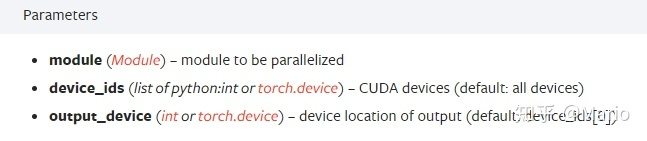
module即表示你定义的模型，device_ids表示你训练的device，output_device这个参数表示输出结果的device，而这最后一个参数output_device一般情况下是省略不写的，那么默认就是在device_ids[0]，也就是第一块卡上，也就解释了为什么第一块卡的显存会占用的比其他卡要更多一些。进一步说也就是当你调用nn.DataParallel的时候，只是在你的input数据是并行的，但是你的output loss却不是这样的，每次都会在第一块GPU相加计算，这就造成了第一块GPU的负载远远大于剩余其他的显卡。

下面来具体讲讲nn.DataParallel中是怎么做的。

首先在前向过程中，你的输入数据会被划分成多个子部分（以下称为副本）送到不同的device中进行计算，而你的模型module是在每个device上进行复制一份，也就是说，输入的batch是会被平均分到每个device中去，但是你的模型module是要拷贝到每个devide中去的，每个模型module只需要处理每个副本即可，当然你要保证你的batch size大于你的gpu个数。然后在反向传播过程中，每个副本的梯度被累加到原始模块中。概括来说就是：DataParallel 会自动帮我们将数据切分 load 到相应 GPU，将模型复制到相应 GPU，进行正向传播计算梯度并汇总。

注意还有一句话，官网中是这样描述的：

The parallelized module must have its parameters and buffers on device_ids[0] before running this DataParallel module.

意思就是：在运行此DataParallel模块之前，并行化模块必须在device_ids [0]上具有其参数和缓冲区。在执行DataParallel之前，会首先把其模型的参数放在device_ids[0]上，一看好像也没有什么毛病，其实有个小坑。我举个例子，服务器是八卡的服务器，刚好前面序号是0的卡被别人占用着，于是你只能用其他的卡来，比如你用2和3号卡，如果你直接指定device_ids=[2, 3]的话会出现模型初始化错误，类似于module没有复制到在device_ids[0]上去。那么你需要在运行train之前需要添加如下两句话指定程序可见的devices，如下：

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

当你添加这两行代码后，那么device_ids[0]默认的就是第2号卡，你的模型也会初始化在第2号卡上了，而不会占用第0号卡了。这里简单说一下设置上面两行代码后，那么对这个程序而言可见的只有2和3号卡，和其他的卡没有关系，这是物理上的号卡，逻辑上来说其实是对应0和1号卡，即device_ids[0]对应的就是第2号卡，device_ids[1]对应的就是第3号卡。（当然你要保证上面这两行代码需要定义在

device_ids = [0, 1]   
net = torch.nn.DataParallel(net, device_ids=device_ids)

这两行代码之前，一般放在train.py中import一些package之后。）

那么在训练过程中，你的优化器同样可以使用nn.DataParallel，如下两行代码：(一般不用)

optimizer = torch.optim.SGD(net.parameters(), lr=lr)    
optimizer = nn.DataParallel(optimizer, device_ids=device_ids)

那么使用nn.DataParallel后，事实上DataParallel也是一个Pytorch的nn.Module，那么你的模型和优化器都需要使用.module来得到实际的模型和优化器，如下：

保存模型：<br>
torch.save(net.module.state_dict(), path)<br>
加载模型：<br>
net=nn.DataParallel(Resnet18())<br>
net.load_state_dict(torch.load(path))<br>
net=net.module<br>
优化器使用：<br>
optimizer.step() --> optimizer.module.step()<br>

(忽略)还有一个问题就是，如果直接使用nn.DataParallel的时候，训练采用多卡训练，会出现一个warning：

UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; 
will instead unsqueeze and return a vector.

首先说明一下：每张卡上的loss都是要汇总到第0张卡上求梯度，更新好以后把权重分发到其余卡。但是为什么会出现这个warning，这其实和nn.DataParallel中最后一个参数dim有关，其表示tensors被分散的维度，默认是0，nn.DataParallel将在dim0（批处理维度）中对数据进行分块，并将每个分块发送到相应的设备。单卡的没有这个warning，多卡的时候采用nn.DataParallel训练会出现这个warning，由于计算loss的时候是分别在多卡计算的，那么返回的也就是多个loss，你使用了多少个gpu，就会返回多少个loss。（有人建议DataParallel类应该有reduce和size_average参数，比如用于聚合输出的不同loss函数，最终返回一个向量，有多少个gpu，返回的向量就有几维。）